# Softmax Classification: Affine Layer + Softmax Activation Layer

This notebook presents one of the most simple multiclass classification models: An affine layer followed by Softmax layer.

Some key points of a "softmax layer":

- A softmax layer transforms an $N$-dimensional vector to a $C$-dimensional vector with norm 1 and all its components between 0 and 1. Usually $C$ is the number of classes.


- The linear layhas a set of weights $\bf{W}$ and a bias vector $\bf{b}$.


- The output of the model  is a vector representing the probability of each class.

Now let us build a softmax layer that given an input vector with `n_feat` features maps it to a `n_class` dimensional vector.

http://cs231n.github.io/neural-networks-case-study/

#### Pyplot in julia

https://github.com/JuliaPy/PyPlot.jl#exported-functions

#### Crossentropy 
https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/

https://en.wikipedia.org/wiki/Cross_entropy

https://www.youtube.com/watch?v=-xautwSTZIY


In [5]:
using PyPlot
plt[:style][:use]("ggplot") # This line is for making plots in GGPLOT style

using DataFrames
using BenchmarkTools

# Generate toy data

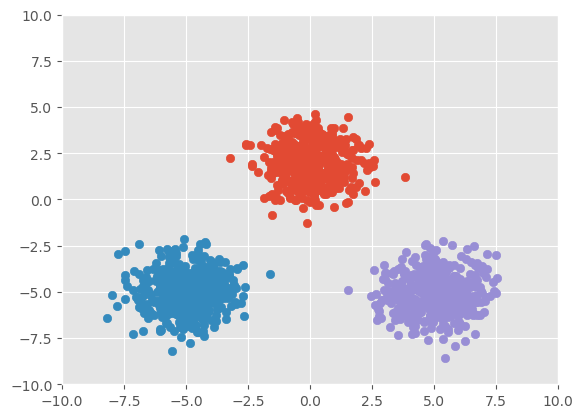

(-10, 10)

In [16]:
srand(1234)

blob1 = [0 2]   .+  randn(500, 2)
blob2 = [-5 -5] .+  randn(500, 2)
blob3 = [5 -5]  .+  randn(500, 2)

PyPlot.scatter(blob1[:, 1], blob1[:, 2])
PyPlot.scatter(blob2[:, 1], blob2[:, 2])
PyPlot.scatter(blob3[:, 1], blob3[:, 2])

PyPlot.xlim(-10, 10)
PyPlot.ylim(-10, 10)



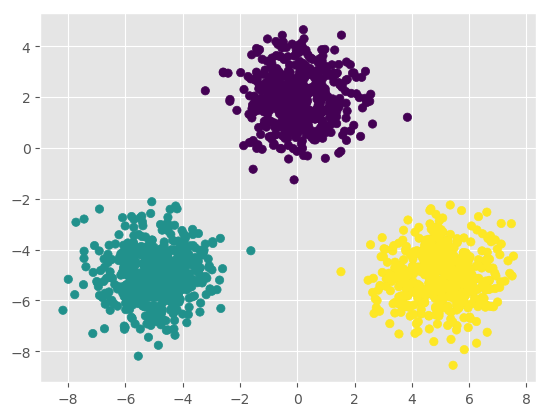

PyObject <matplotlib.collections.PathCollection object at 0x140ca9ed0>

In [17]:
Xblobs = vcat(blob1,blob2,blob3)'
yblobs = Array{Int}(vcat(ones(500), ones(500)+1, ones(500) + 2));
PyPlot.scatter(Xblobs[1,:], Xblobs[2,:], c=yblobs)

## Define Crossentropy loss and softmax layer



In [18]:
type CrossEntropyLossLayer end

In [19]:
function forward(loss::CrossEntropyLossLayer, y_prob::Vector, y::Vector)
    """
    Should this function do the onehot encoding?
    In order to save memory it seems reasonable but...
    C = number of classes
    e(t) = Encoding (as vector) of class t
          loss (h(x), e(t)) = \sum_{i=1}^{C} e(t)_i  log (h(x)_i)
    
    Returns the loss between the batch
    """
    # This breaks if Y_hat_batch contains 0 because log(0)= -Inf
    # return - sum(Y_encoded.*log.(Y_hat_batch))
    # TODO: Make it resilient to the -Inf problem: 
    # one possible solution could be take the max(0.00001, x)
    cross_entropy = 0.

    @inbounds for d in 1:length(y)
        cross_entropy +=  log(y_prob[d])
    end
    return -cross_entropy
end

forward (generic function with 1 method)

In [20]:
abstract type ActivationLayer end

type SoftMaxLayer{T} <: ActivationLayer 
    """
    Standard Sotmax layer.
    The output of this layer for a given input is meant to be 
        
        output_k = e^(W*X + b)_k /sum_j (W*X + b)_j

    """
    input_dim::Int
    output_dim::Int
    W::Array{T}
    b::Vector{T}
    seed::Int
end

function SoftMaxLayer{T}(input_dim, output_dim; seed=1234) where T<:Real
    srand(seed)
    return SoftMaxLayer{T}(input_dim,
                           output_dim,
                           randn(T, output_dim, input_dim)/sqrt(input_dim),
                           zeros(output_dim),
                           seed)
end

Base.show(io::IO, l::SoftMaxLayer{T}) where T <: Number = \,
print(io,"SoftMaxLayer{$T} [input_dim: $(l.input_dim), ouput_dim: $(l.output_dim)]")

In [21]:
input_dim = 2
output_dim = 3

softmax = SoftMaxLayer{Float32}(input_dim, output_dim)

SoftMaxLayer{Float32} [input_dim: 2, ouput_dim: 3]

### Propagate information through the softmax

In [22]:
# Elements in the batch must be column vectors
X_batch = Xblobs[:, 1:10]

2×10 Array{Float64,2}:
 0.867347  -0.901744  -0.494479  -0.902914  …  -0.271735  0.502334  -0.516984
 3.43165    0.352484   0.985333   1.03181       0.952064  0.408939   1.527   

In [31]:
function forward(softmax_layer::SoftMaxLayer, Xbatch::Array)
    """
    Layer shrinking the output to [0,1] values.
    Notice that sum(exp(Xbatch),1) will generate a Matrix with as many elements as
    columns in Xbatch. 
    """
    Xbatch_out = exp.(softmax_layer.W * Xbatch .+ softmax_layer.b)
    return Xbatch_out./sum(Xbatch_out, 1)  # Generating an array here every call
end

forward (generic function with 2 methods)

In [32]:
function forward2(softmax_layer::SoftMaxLayer, Xbatch::Array)
    """
    Layer shrinking the output to [0,1] values.
    """
    Xbatch_out = exp.(softmax_layer.W * Xbatch .+ softmax_layer.b)
    
    @inbounds for j in 1:size(Xbatch,2)
        Xbatch_out[:,j] .= view(Xbatch_out,:,j)./sum(view(Xbatch_out,:,j))
    end
        
    return Xbatch_out
end

forward2 (generic function with 1 method)

In [33]:
# Columns k of p_y_X_batch contains the probability of X_batch[:,k] 
# belonging to each of the different classes.
p_y_X_batch = forward(softmax, X_batch)

3×10 Array{Float64,2}:
 0.001167   0.0910838  0.0465946  …  0.0617561  0.293546  0.0162906
 0.0287291  0.437159   0.296308      0.285115   0.261044  0.209675 
 0.970104   0.471757   0.657098      0.653129   0.445409  0.774034 

In [34]:
forward(softmax, X_batch)

3×10 Array{Float64,2}:
 0.001167   0.0910838  0.0465946  …  0.0617561  0.293546  0.0162906
 0.0287291  0.437159   0.296308      0.285115   0.261044  0.209675 
 0.970104   0.471757   0.657098      0.653129   0.445409  0.774034 

In [35]:
forward2(softmax, X_batch)

3×10 Array{Float64,2}:
 0.001167   0.0910838  0.0465946  …  0.0617561  0.293546  0.0162906
 0.0287291  0.437159   0.296308      0.285115   0.261044  0.209675 
 0.970104   0.471757   0.657098      0.653129   0.445409  0.774034 

In [36]:
@benchmark forward(softmax, X_batch)

BenchmarkTools.Trial: 
  memory estimate:  1.36 KiB
  allocs estimate:  8
  --------------
  minimum time:     650.859 ns (0.00% GC)
  median time:      671.653 ns (0.00% GC)
  mean time:        762.030 ns (9.54% GC)
  maximum time:     19.505 μs (90.46% GC)
  --------------
  samples:          10000
  evals/sample:     163

In [37]:
@benchmark forward2(softmax, X_batch)

BenchmarkTools.Trial: 
  memory estimate:  1.34 KiB
  allocs estimate:  16
  --------------
  minimum time:     648.539 ns (0.00% GC)
  median time:      671.206 ns (0.00% GC)
  mean time:        782.402 ns (12.26% GC)
  maximum time:     12.432 μs (88.14% GC)
  --------------
  samples:          10000
  evals/sample:     165

#### Predict the class of every element in a minibatch

In [38]:
"""
    Function to predict the class labels for a given batch of class probabilities.
    The probabilities for each class should be organized in columns.
    Therefore 
        - the number of rows in Xprobs must be the number of classes
        - the number of columns in Xprobs must be the number of elements in the batch
"""
function predict_class(Xprobs::Array)
    
    predicted_classes = zeros(Int, size(Xprobs,2))
    
    @inbounds for i in 1:size(Xprobs, 2)
        predicted_classes[i] = indmax(view(Xprobs,:,i))
    end
    return predicted_classes
end

predict_class

In [39]:
X_probs = forward(softmax, X_batch)

3×10 Array{Float64,2}:
 0.001167   0.0910838  0.0465946  …  0.0617561  0.293546  0.0162906
 0.0287291  0.437159   0.296308      0.285115   0.261044  0.209675 
 0.970104   0.471757   0.657098      0.653129   0.445409  0.774034 

In [40]:
@benchmark predict_class(X_probs)

BenchmarkTools.Trial: 
  memory estimate:  640 bytes
  allocs estimate:  11
  --------------
  minimum time:     145.886 ns (0.00% GC)
  median time:      154.242 ns (0.00% GC)
  mean time:        188.461 ns (16.08% GC)
  maximum time:     1.872 μs (88.03% GC)
  --------------
  samples:          10000
  evals/sample:     836

#### Crossentropy loss

In [ ]:
function crossentropyloss_naive(y, y_pred)
    batch_size = length(y)
    ce = zero(eltype(y_pred))
    
    @inbounds for k in batch_size
        
        ce += -log(y_pred[y[k],k])
    end
    return ce/batch_size
end

In [41]:
function crossentropyloss(y, y_pred)
    batch_size = length(y)
    ce = zero(eltype(y_pred))
    
    @inbounds for k in batch_size
        ce += -log(y_pred[y[k],k])
    end
    return ce/batch_size
end

crossentropyloss (generic function with 1 method)

In [93]:
y_pred = forward(softmax, X_batch)
ce = crossentropyloss(yblobs[1:10], y_pred)
ce

0.4117168968518983

In [94]:
@benchmark crossentropyloss(yblobs[1:10], y_pred)

BenchmarkTools.Trial: 
  memory estimate:  208 bytes
  allocs estimate:  3
  --------------
  minimum time:     130.602 ns (0.00% GC)
  median time:      149.832 ns (0.00% GC)
  mean time:        189.131 ns (14.18% GC)
  maximum time:     11.081 μs (96.13% GC)
  --------------
  samples:          10000
  evals/sample:     888

#### Compute the gradient of the softmax

In [178]:
function grad(softmax::SoftMaxLayer, Xbatch, y)
    
    y_pred = forward(softmax, Xbatch)
    ce = crossentropyloss(y, y_pred)
    scores = copy(y_pred)
    
    @inbounds for k in y
        scores[y[k],k] -= 1
    end
    
    scores .= scores/length(y)
    grad_W =  scores * Xbatch'
    grad_b = sum(scores, 2)[:]
    
    return grad_W, grad_b, ce
end

grad (generic function with 1 method)

In [96]:
size(X_batch), size(yblobs[1:10])

((2, 10), (10,))

In [97]:
grad_W, grad_b, ce = grad(softmax, X_batch, yblobs[1:10])

([-0.712429 -3.36447; -0.0584817 0.196576; 0.0926549 1.13672], [-0.8746, 0.206108, 0.668493], 0.4117168968518983)

In [99]:
Xb = Xblobs[:, 1:5]
yb = yblobs[1:5]

grad_W, grad_b, ce = grad(softmax, Xb, yb)

([-0.891708 -3.40491; -0.148721 0.208139; 0.0596041 1.42026], [-0.964756, 0.229552, 0.735204], 0.9395911650035238)

# Train the softmax using SGD

In [179]:
input_dim = 2
output_dim = 3
softmax = SoftMaxLayer{Float32}(input_dim, output_dim)

learning_rate = 0.01
batch_size = 20
averaged_loss = 0
print_every_k = 50

for i in 1:500
    averaged_loss = 0
    for j in 1:batch_size:(length(yblobs)-batch_size)
        grad_W, grad_b, ce = grad(softmax, Xblobs[:,j:j+batch_size], yblobs[j:j+batch_size])
        softmax.W -= learning_rate * grad_W
        softmax.b -= learning_rate * grad_b
        averaged_loss += ce
    end
    averaged_loss += ce
    if mod(i, print_every_k) == 0
        println("loss: ",  averaged_loss)
    end
end

loss: 0.2933915242038412
loss: 0.482951851726049
loss: 0.6778563118753659
loss: 0.8729394246090741
loss: 1.0677977213769556
loss: 1.2625719039431762
loss: 1.4573537030041372
loss: 1.652302069016117
loss: 1.8474264013769266
loss: 2.042774338173413


In [180]:
## Accuracy in the whole train set
Xprob = forward(softmax, Xblobs)
acc = sum(predict_class(Xprob) .== yblobs) /length(yblobs)
println(acc)

0.9653333333333334


### Plotting the decision boundary


Here we introduce a function, `make_grid` that will be used to generate a 2D grid of equidistant points. The grid can be used to visualize the regions of the feature space that the model assigns to each label. To do so, each point from the grid will be evaluated and the predicted class (an integer value) will be assigned to a color.

In [182]:
function make_grid(X; n_splits=100)
    a = linspace(Int(floor(minimum(X[1, :]))), floor(maximum(X[1, :])+1),n_splits)
    b = linspace(Int(floor(minimum(X[2, :]))), floor(maximum(X[2, :])+1),n_splits)
    grid_a = vec(broadcast((x,y) -> x, a, b'))
    grid_b = vec(broadcast((x,y) -> y, a, b'));
    Xgrid = hcat(grid_a, grid_b);
    return Xgrid'
end

make_grid (generic function with 1 method)

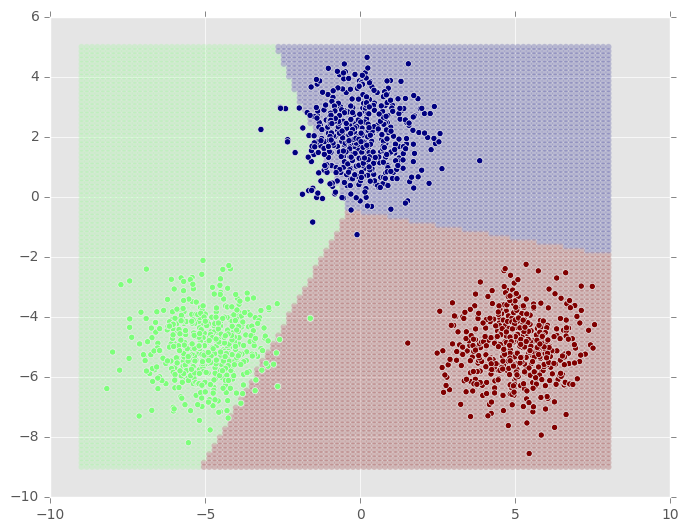

PyObject <matplotlib.collections.PathCollection object at 0x125f6fa90>

In [183]:
Xgrid = make_grid(Xblobs; n_splits=100);
ygrid = predict_class(forward(softmax, Xgrid));

PyPlot.scatter(Xgrid[1,:], Xgrid[2,:], c=ygrid, alpha=0.2)
PyPlot.scatter(Xblobs[1,:], Xblobs[2,:], c=yblobs)

In [151]:
yprobgrid = forward(softmax, Xgrid)

3×10000 Array{Float64,2}:
 3.91643e-173  9.83457e-171  2.46957e-168  …  1.0           1.0         
 1.0           1.0           1.0              8.57036e-149  3.41298e-151
 3.94574e-46   4.13778e-44   4.33917e-42      1.44353e-87   6.02837e-88 

## 0) Plotting the model decision boundaries before learning


In [184]:
# Define softmax model
input_dim = 2
output_dim = 3
softmax = SoftMaxLayer{Float32}(input_dim, output_dim)

SoftMaxLayer{Float32} [input_dim: 2, ouput_dim: 3]

In [185]:
Xgrid = make_grid(Xblobs; n_splits=100);
ygrid = predict_class(forward(softmax, Xgrid));

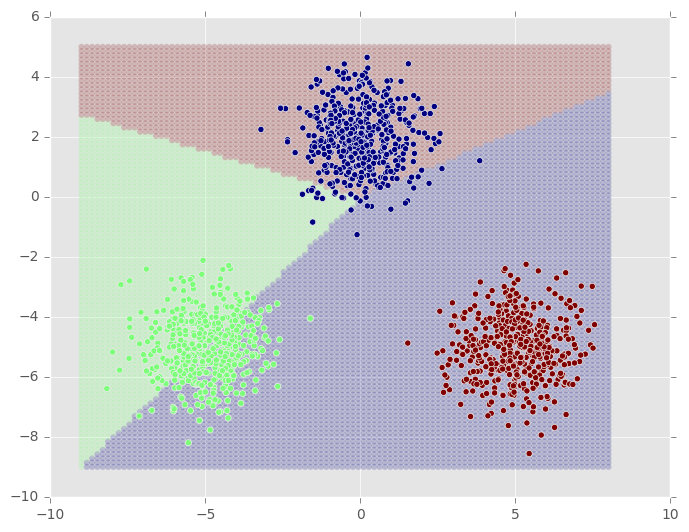

PyObject <matplotlib.collections.PathCollection object at 0x1251adcf8>

In [186]:
# This line plots the "decision boundary", which is simply a rectangle
# containing many points each of which is evaluated by the model and its 
# class is colored
PyPlot.scatter(Xgrid[1,:], Xgrid[2,:], c=ygrid, alpha=0.2, marker ="o") 

# This line plots the real data
PyPlot.scatter(Xblobs[1,:], Xblobs[2,:], c=yblobs, marker = "o")

#### Coloring differently the mistakes

We can color differently the mistakes made by the classifier 

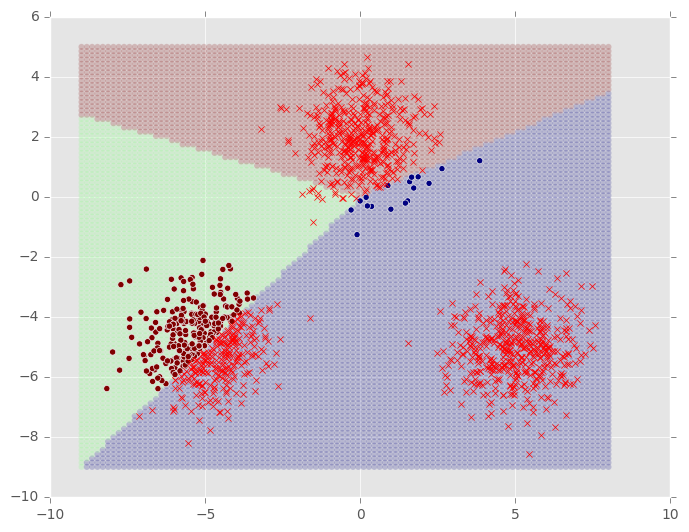

PyObject <matplotlib.collections.PathCollection object at 0x12726aeb8>

In [194]:
# Save indices for the error and non errors
y_pred = predict_class(forward(softmax, Xblobs)) 
errors = y_pred .!= yblobs;
non_errors = y_pred .== yblobs;
incorrectly_classified = view(Xblobs,:,errors)
correctly_classified =  view(Xblobs,:,non_errors)

Xgrid = make_grid(Xblobs; n_splits=100);
ygrid = predict_class(forward(softmax, Xgrid));

PyPlot.scatter(Xgrid[1,:], Xgrid[2,:], c=ygrid, alpha=0.2, marker ="o") 
PyPlot.scatter(correctly_classified[1,:], correctly_classified[2,:], c=yblobs[non_errors], marker = "o")
PyPlot.scatter(incorrectly_classified[1,:], incorrectly_classified[2,:], c="r", marker = "x")

## 1) Learning with  minibatches

A classical way to do learning is by splitting the data into batches. 

A batch of size `n_batch` is simply a collection containing `n_batch` examples. 

#### minibatch programming notes

For a given epoch containing `n_examples`, assuming we are using a batch size containing `n_batch` examples, we will split our data into `n_examples`/`n_batch` batches. Each batch will containg `n_batch` examples except the last one which might contain less if the number examples is not divisible by `n_batch`. 

If X contains our data in columns, `X[:, j:j + n_batch]` will be an Array containg the examples from position `j` to position `j + n_batch`. 

- Every call of `Xbatch = X[:, j:j + n_batch]` will create a new Array
- Every call of `Xbatch = view(X, :, j:j + n_batch)` will create a new Subarray 

SubArrays allocate a very small amount of memory and therefore are usually a better choice.


#### minibatch optimization notes

The bigger a minibatch is, the most profit we can get calling highly optimized BLAS/clBLAS functions, nevertheless the speed gain (in number of examples processed per second) might not translate  into a loss gain (decrese on our loss objective).

In [195]:
input_dim = 2
output_dim = 3
softmax = SoftMaxLayer{Float32}(input_dim, output_dim)

learning_rate = 0.0001
batch_size = 100
averaged_loss = 0
print_every_k = 200
n_epochs = 3000

for i in 1:n_epochs
    averaged_loss = 0
    for j in 1:batch_size:(length(yblobs)-batch_size)
        grad_W, grad_b, ce = grad(softmax, Xblobs[:, j:j+batch_size], yblobs[j:j+batch_size])
        softmax.W -= learning_rate * grad_W
        softmax.b -= learning_rate * grad_b
        averaged_loss += ce
    end
    averaged_loss += ce
    if mod(i, print_every_k) == 0
        y_pred = predict_class(forward(softmax,Xblobs)) 
        acc = sum(y_pred .== yblobs) /length(yblobs)
        println("averaged loss: ",  averaged_loss, "\tacc:", acc)
    end
    
end

averaged loss: 0.4665648577492064	acc:0.3426666666666667
averaged loss: 0.078846579153713	acc:0.6626666666666666
averaged loss: 0.039358238575727025	acc:0.92
averaged loss: 0.029859900384744596	acc:0.946
averaged loss: 0.025008081525122867	acc:0.954
averaged loss: 0.022011837688742028	acc:0.9593333333333334
averaged loss: 0.01998832216094076	acc:0.964
averaged loss: 0.01854002009808646	acc:0.966
averaged loss: 0.017456708418333015	acc:0.9686666666666667
averaged loss: 0.016618451712774873	acc:0.9673333333333334
averaged loss: 0.015952605608071133	acc:0.9653333333333334
averaged loss: 0.015413424573154571	acc:0.9673333333333334
averaged loss: 0.01497083669483558	acc:0.9666666666666667
averaged loss: 0.014604144120285127	acc:0.964
averaged loss: 0.01429844585371292	acc:0.9613333333333334


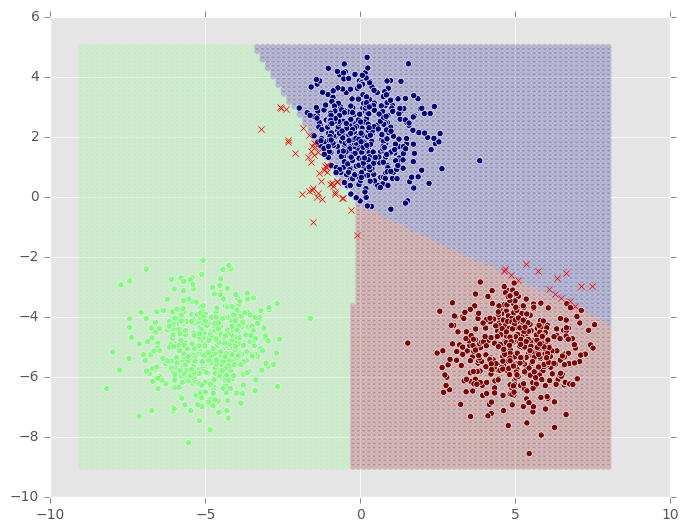

PyObject <matplotlib.collections.PathCollection object at 0x12684eb00>

In [196]:
# Save indices for the error and non errors
y_pred = predict_class(forward(softmax, Xblobs)) 
errors = y_pred .!= yblobs;
non_errors = y_pred .== yblobs;
incorrectly_classified = view(Xblobs,:,errors)
correctly_classified =  view(Xblobs,:,non_errors)

Xgrid = make_grid(Xblobs; n_splits=100);
ygrid = predict_class(forward(softmax, Xgrid));

PyPlot.scatter(Xgrid[1,:], Xgrid[2,:], c=ygrid, alpha=0.2, marker ="o") 
PyPlot.scatter(correctly_classified[1,:], correctly_classified[2,:], c=yblobs[non_errors], marker = "o")
PyPlot.scatter(incorrectly_classified[1,:], incorrectly_classified[2,:], c="r", marker = "x")

## 2) Learning minibatches changed every epoch

Now we will see that **random minibatching helps to scape form local minima.**

The following example uses the same hipeparameters of the previous example but shuffles the minibatches at every epoch. The results improve substantially.

In [197]:
input_dim = 2
output_dim = 3
softmax = SoftMaxLayer{Float32}(input_dim, output_dim)

learning_rate = 0.0001
batch_size = 100
averaged_loss = 0
print_every_k = 200
n_epochs = 3000

#### Adding the following lines to get minibatches  ## rand_batch ##
indicies_data = Array(1:length(yblobs))

for i in 1:n_epochs
    
    srand(1234)                            ## rand_batch ##
    shuffle!(indicies_data)                ## rand_batch ##

    averaged_loss = 0
    for j in 1:batch_size:(length(yblobs)-batch_size)
        
        grad_W, grad_b, ce = grad(softmax,
                                  Xblobs[:, indicies_data[j:j+batch_size]],
                                  yblobs[indicies_data[j:j+batch_size]])
    
        softmax.W -= learning_rate * grad_W
        softmax.b -= learning_rate * grad_b
        averaged_loss += ce
    end
    
    averaged_loss += ce
    
    if mod(i, print_every_k) == 0
        y_pred = predict_class(forward(softmax, Xblobs)) 
        acc = sum(y_pred .== yblobs) /length(yblobs)
        println("averaged loss: ",  averaged_loss, "\tacc:", acc)
    end
   
end

averaged loss: 0.34855713878462535	acc:0.338
averaged loss: 0.07374667789895735	acc:0.674
averaged loss: 0.04194739140746118	acc:0.8913333333333333
averaged loss: 0.03572516486253446	acc:0.9446666666666667
averaged loss: 0.028221933996926553	acc:0.9673333333333334
averaged loss: 0.028289909237940024	acc:0.9766666666666667
averaged loss: 0.030762666447860538	acc:0.98
averaged loss: 0.017905626996081885	acc:0.9826666666666667
averaged loss: 0.03143145589858756	acc:0.9853333333333333
averaged loss: 0.02003268824018217	acc:0.988
averaged loss: 0.029716022033839294	acc:0.988
averaged loss: 0.022499453119519668	acc:0.9886666666666667
averaged loss: 0.021795612682142897	acc:0.9886666666666667
averaged loss: 0.012903864080544909	acc:0.9893333333333333
averaged loss: 0.016684451122610845	acc:0.9893333333333333


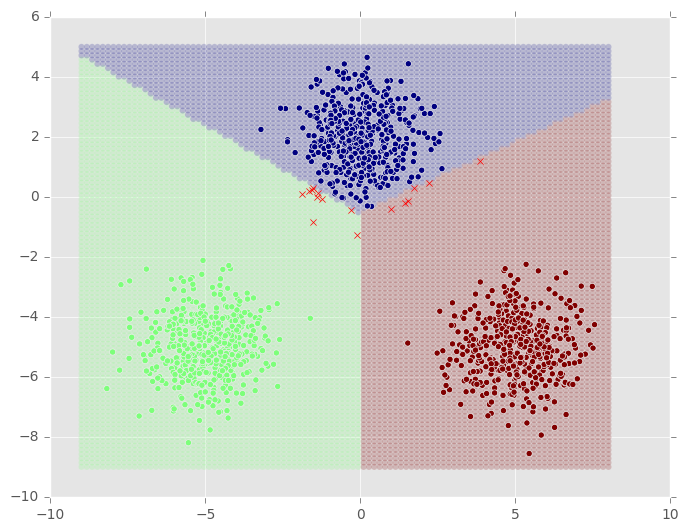

PyObject <matplotlib.collections.PathCollection object at 0x126fe47b8>

In [198]:
# Save indices for the error and non errors
y_pred = predict_class(forward(softmax, Xblobs)) 
errors = y_pred .!= yblobs;
non_errors = y_pred .== yblobs;
incorrectly_classified = view(Xblobs,:,errors)
correctly_classified =  view(Xblobs,:,non_errors)

Xgrid = make_grid(Xblobs; n_splits=100);
ygrid = predict_class(forward(softmax, Xgrid));

PyPlot.scatter(Xgrid[1,:], Xgrid[2,:], c=ygrid, alpha=0.2, marker ="o") 
PyPlot.scatter(correctly_classified[1,:], correctly_classified[2,:], c=yblobs[non_errors], marker = "o")
PyPlot.scatter(incorrectly_classified[1,:], incorrectly_classified[2,:], c="r", marker = "x")

# Idea 1
# After learning -> Learn with the mistakes only

Sometimes its hard to get perfectly fitted models on the train data (it might be even preferable). Nevertheless it might be a good idea to finetule the learned model using only the missclassified samples.

In [207]:
input_dim = 2
output_dim = 3
softmax = SoftMaxLayer{Float32}(input_dim, output_dim)

learning_rate = 0.0001
batch_size = 100
averaged_loss = 0
print_every_k = 200
n_epochs = 3000

#### Adding the following lines to get minibatches  ## rand_batch ##
indicies_data = Array(1:length(yblobs))

for i in 1:n_epochs
    
    srand(1234)                            ## rand_batch ##
    shuffle!(indicies_data)                ## rand_batch ##

    averaged_loss = 0
    for j in 1:batch_size:(length(yblobs)-batch_size)
        
        grad_W, grad_b, ce = grad(softmax,
                                  Xblobs[:,indicies_data[j:j+batch_size]],
                                  yblobs[indicies_data[j:j+batch_size]])
    
        softmax.W -= learning_rate * grad_W
        softmax.b -= learning_rate * grad_b
        averaged_loss += ce
    end
    
    averaged_loss += ce
    
    if mod(i, print_every_k) == 0
        y_pred = predict_class(forward(softmax, Xblobs)) 
        acc = sum(y_pred .== yblobs) /length(yblobs)
        println("averaged loss: ",  averaged_loss, "\tacc:", acc)
    end
   
end

averaged loss: 0.34855713878462535	acc:0.338
averaged loss: 0.07374667789895735	acc:0.674
averaged loss: 0.04194739140746118	acc:0.8913333333333333
averaged loss: 0.03572516486253446	acc:0.9446666666666667
averaged loss: 0.028221933996926553	acc:0.9673333333333334
averaged loss: 0.028289909237940024	acc:0.9766666666666667
averaged loss: 0.030762666447860538	acc:0.98
averaged loss: 0.017905626996081885	acc:0.9826666666666667
averaged loss: 0.03143145589858756	acc:0.9853333333333333
averaged loss: 0.02003268824018217	acc:0.988
averaged loss: 0.029716022033839294	acc:0.988
averaged loss: 0.022499453119519668	acc:0.9886666666666667
averaged loss: 0.021795612682142897	acc:0.9886666666666667
averaged loss: 0.012903864080544909	acc:0.9893333333333333
averaged loss: 0.016684451122610845	acc:0.9893333333333333


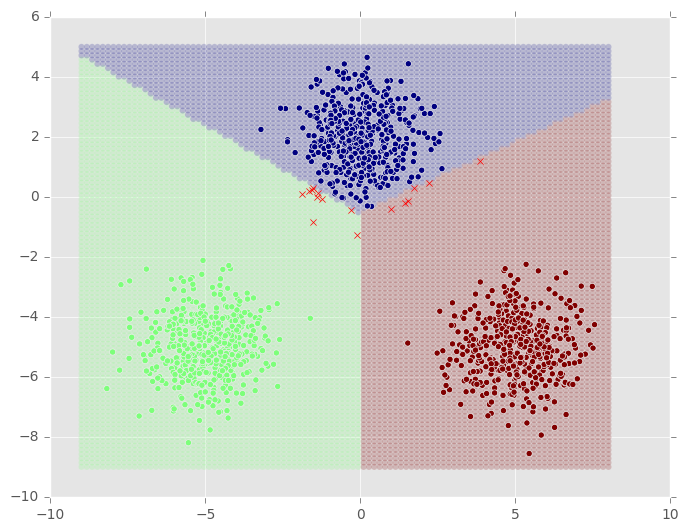

PyObject <matplotlib.collections.PathCollection object at 0x127d199b0>

In [208]:
# Save indices for the error and non errors
y_pred = predict_class(forward(softmax, Xblobs)) 
errors = y_pred .!= yblobs;
non_errors = y_pred .== yblobs;
incorrectly_classified = view(Xblobs,:,errors)
correctly_classified =  view(Xblobs,:,non_errors)

Xgrid = make_grid(Xblobs; n_splits=100);
ygrid = predict_class(forward(softmax, Xgrid));

PyPlot.scatter(Xgrid[1,:], Xgrid[2,:], c=ygrid, alpha=0.2, marker ="o") 
PyPlot.scatter(correctly_classified[1,:], correctly_classified[2,:], c=yblobs[non_errors], marker = "o")
PyPlot.scatter(incorrectly_classified[1,:], incorrectly_classified[2,:], c="r", marker = "x")

### Finetunning of the incorrectly classifed examples

After learning we can use only the incorrectly classified datapoints

In [209]:
y_pred = predict_class(forward(softmax, Xblobs)) 
errors = y_pred .!= yblobs;
non_errors = y_pred .== yblobs;

X_incorrect = Xblobs[:,errors]
y_incorrect= yblobs[errors];

In [210]:
learning_rate = 0.0001
batch_size = 1
averaged_loss = 0
n_epochs = 1000
print_every_k = 50

#### Adding the following lines to get minibatches  ## rand_batch ##
indicies_data = Array(1:length(y_incorrect))

for i in 1:n_epochs
    
    srand(1234)                            ## rand_batch ##
    shuffle!(indicies_data)                ## rand_batch ##

    averaged_loss = 0
    for j in 1:batch_size:(length(y_incorrect)-batch_size)
        
        grad_W, grad_b, ce = grad(softmax,
                                  X_incorrect[:, indicies_data[j:j+batch_size]],
                                  y_incorrect[indicies_data[j:j+batch_size]])
    
        softmax.W -= learning_rate * grad_W
        softmax.b -= learning_rate * grad_b
        averaged_loss += ce
    end
    
    averaged_loss += ce
    
    if mod(i, print_every_k) == 0
        y_pred = predict_class(forward(softmax, X_incorrect)) 
        acc = sum(y_pred .== y_incorrect) /length(y_incorrect)
        println("averaged loss: ",  averaged_loss, "\tacc:", acc)
    end
end

averaged loss: 7.288428473603044	acc:0.3125
averaged loss: 7.209312687805059	acc:0.5
averaged loss: 6.787991814186536	acc:0.625
averaged loss: 6.282808570183955	acc:0.6875
averaged loss: 6.41542916203435	acc:0.8125
averaged loss: 5.664540337611952	acc:0.875
averaged loss: 5.48102504789051	acc:0.875
averaged loss: 5.36136372270996	acc:0.875
averaged loss: 4.696967715634222	acc:0.875
averaged loss: 4.839601219961419	acc:0.875
averaged loss: 4.569176891600097	acc:0.875
averaged loss: 4.243798612213325	acc:0.875
averaged loss: 4.423736095891551	acc:1.0
averaged loss: 3.9326829987475223	acc:1.0
averaged loss: 3.8510793349705277	acc:1.0
averaged loss: 3.822787705050581	acc:1.0
averaged loss: 3.337686933341198	acc:1.0
averaged loss: 3.5309219542253247	acc:1.0
averaged loss: 3.3430789343314555	acc:1.0
averaged loss: 3.119833635886118	acc:1.0


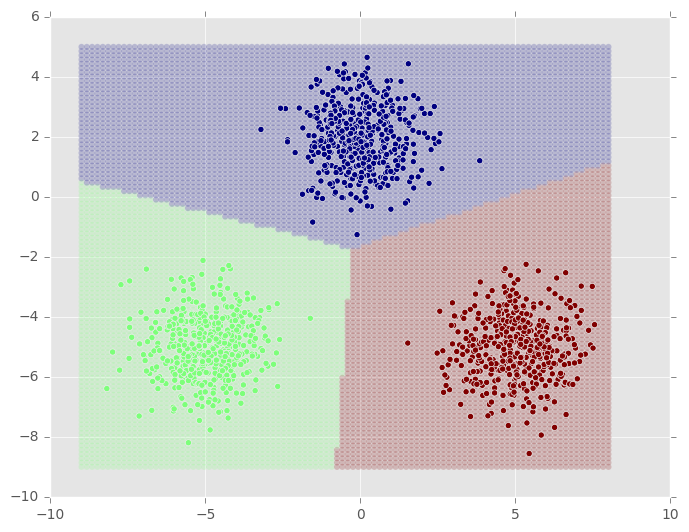

PyObject <matplotlib.collections.PathCollection object at 0x11e27dfd0>

In [211]:
# Save indices for the error and non errors
y_pred = predict_class(forward(softmax, Xblobs)) 
errors = y_pred .!= yblobs;
non_errors = y_pred .== yblobs;
incorrectly_classified = view(Xblobs,:,errors)
correctly_classified =  view(Xblobs,:,non_errors)

Xgrid = make_grid(Xblobs; n_splits=100);
ygrid = predict_class(forward(softmax, Xgrid));

PyPlot.scatter(Xgrid[1,:], Xgrid[2,:], c=ygrid, alpha=0.2, marker ="o") 
PyPlot.scatter(correctly_classified[1,:], correctly_classified[2,:], c=yblobs[non_errors], marker = "o")
PyPlot.scatter(incorrectly_classified[1,:], incorrectly_classified[2,:], c="r", marker = "x")

# Idea 2

# After learning -> ??

- Measure distance between mistakes and true samples from the other class.
- Try to maximize margins with only the miscclassified instances after learning. (remember SVMS do not scale well with the amount of data).

# Limitations of a softmax classifier

A softmax layer (that is a linear layer with softmax activation function) cannot classify any arbitrary complex problem in the original feature space


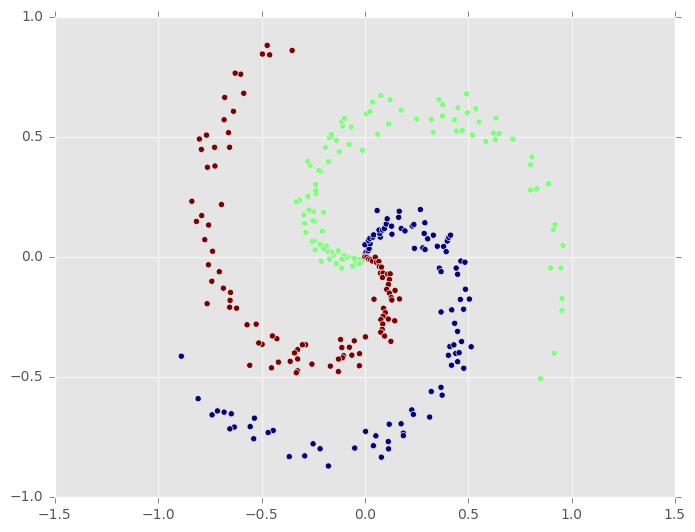

Size of X =(2, 300)


(-1.5, 1.5)

In [223]:
T = Float32
df = DataFrames.readtable("spiraldata.csv");
X = Array{T}(hcat(df[:x1],df[:x2]))
X = X'
y = Array{Int}(df[:y]) +1;
println("Size of X =", size(X))
PyPlot.scatter(X[1,:], X[2,:], c=y)
PyPlot.xlim(-1.5,1.5)

In [230]:
input_dim = 2
output_dim = 3
softmax = SoftMaxLayer{Float32}(input_dim, output_dim)

learning_rate = 0.001
batch_size = 25
averaged_loss = 0
print_every_k = 200
n_epochs = 3000

#### Adding the following lines to get minibatches  ## rand_batch ##
indicies_data = Array(1:length(y))

for i in 1:n_epochs
    
    srand(1234)                            ## rand_batch ##
    shuffle!(indicies_data)                ## rand_batch ##

    averaged_loss = 0
    for j in 1:batch_size:(length(y)-batch_size)
        
        grad_W, grad_b, ce = grad(softmax,
                                  X[:,indicies_data[j:j+batch_size]],
                                  y[indicies_data[j:j+batch_size]])
    
        softmax.W -= learning_rate * grad_W
        softmax.b -= learning_rate * grad_b
        averaged_loss += ce
    end
    
    averaged_loss += ce
    
    if mod(i, print_every_k) == 0
        y_pred = predict_class(forward(softmax, X)) 
        acc = sum(y_pred .== y) /length(y)
        println("averaged loss: ",  averaged_loss, "\tacc:", acc)
    end
   
end

averaged loss: 0.4733417	acc:0.36333333333333334
averaged loss: 0.42598024	acc:0.39
averaged loss: 0.34484866	acc:0.4633333333333333
averaged loss: 0.42989814	acc:0.4766666666666667
averaged loss: 0.4843538	acc:0.49
averaged loss: 0.3969492	acc:0.48
averaged loss: 0.4090206	acc:0.4866666666666667
averaged loss: 0.35671505	acc:0.4766666666666667
averaged loss: 0.3713021	acc:0.48333333333333334
averaged loss: 0.38529617	acc:0.48333333333333334
averaged loss: 0.41663307	acc:0.4866666666666667
averaged loss: 0.34637925	acc:0.5
averaged loss: 0.36113113	acc:0.5
averaged loss: 0.33462203	acc:0.5
averaged loss: 0.30095336	acc:0.5


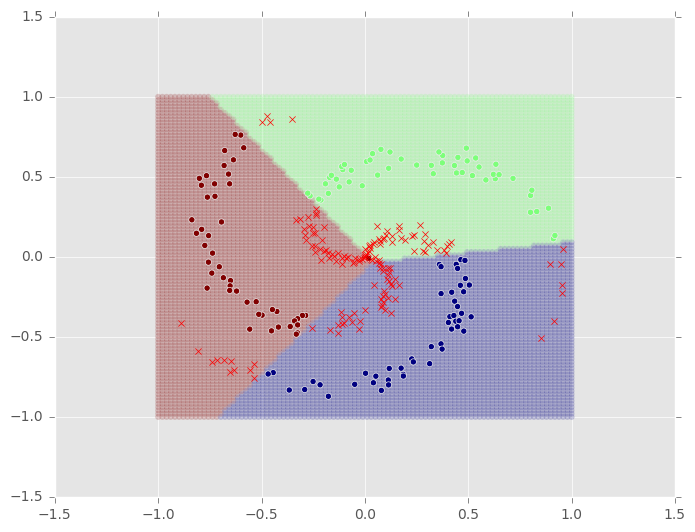

PyObject <matplotlib.collections.PathCollection object at 0x129263748>

In [231]:
# Save indices for the error and non errors
y_pred = predict_class(forward(softmax, X)) 
errors = y_pred .!= y;
non_errors = y_pred .== y;
incorrectly_classified = view(X,:,errors)
correctly_classified =  view(X,:,non_errors)

Xgrid = make_grid(X; n_splits=100);
ygrid = predict_class(forward(softmax, Xgrid));

PyPlot.scatter(Xgrid[1,:], Xgrid[2,:], c=ygrid, alpha=0.2, marker ="o") 
PyPlot.scatter(correctly_classified[1,:], correctly_classified[2,:], c=y[non_errors], marker = "o")
PyPlot.scatter(incorrectly_classified[1,:], incorrectly_classified[2,:], c="r", marker = "x")

In [ ]:
##